In [1]:
# REVERSE TRUE   ==  nld --> eng
# REVERSE FALSE  ==  eng --> nld

REVERSE = True
MAX_LENGTH = 10

In [4]:
torch.cuda.is_available()

False

# Prepare data, create LM

In [5]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

SOS_token = 0
EOS_token = 1

# language class (necessary for w2i, w2c, i2w)
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# load languages from .txt file
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        print('readLangs reverse = true')
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# only use these prefixes
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, reverse=False):
    if reverse:
        return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)
    else:
        return len(p[1].split(' ')) < MAX_LENGTH and \
        len(p[0].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)
        
def filterPairs(pairs, reverse=False):
    return [pair for pair in pairs if filterPair(pair, reverse)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [6]:
input_lang, output_lang, pairs = prepareData('eng', 'nld', reverse=REVERSE)

Reading lines...
readLangs reverse = true
Read 27048 sentence pairs
Trimmed to 1924 sentence pairs
Counting words...
Counted words:
nld 1451
eng 1283


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [11]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [13]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
 
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

# evaluate random sentence from training set
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
        
# evaluate sentence
def evaluateSentence(encoder, decoder, s):
    #print('>', s)
    output_words, attentions = evaluate(encoder, decoder, s)
    #print('< ' +' '.join(output_words))
    return output_words

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it's easier to run multiple experiments easier) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note:: 
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [16]:
# load .pt files as encoder1, attn_decoder1
# torch.load('tensors.pt', map_location=lambda storage, loc: storage)

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
encoder1.load_state_dict(torch.load('models_project6/encoder.pt', map_location=lambda storage, loc: storage))
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, 1, dropout_p=0.1)
attn_decoder1.load_state_dict(torch.load('models_project6/decoder.pt', map_location=lambda storage, loc: storage))


In [17]:
evaluateSentence(encoder1, attn_decoder1, 'je bent verslaafd je bent je bent je .')

['you', 'are', 'both', '.', 'you', 'are', '.', '<EOS>']

In [22]:
# Calculate BLEU Score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

def bleu(lang_pairs):
    references = []
    hypotheses = []
    for lang_pair in lang_pairs:
        nld_sent = lang_pair[0]
        # reference should have extra brackets
        reference = [lang_pair[1].split()]
        hypothesis = evaluateSentence(encoder1, attn_decoder1, nld_sent)[:-1]

        
        
        references.append(reference)
        hypotheses.append(hypothesis)
        print(reference)
    score = corpus_bleu(references, hypotheses)
    
    print('length of corpus: ',len(lang_pairs))
    print('BLEU score:       ',score)
    print('*'*40)
    
    return score

bleu(pairs)

[['i', 'm', '.']]
[['i', 'm', 'tom', '.']]
[['i', 'm', 'fat', '.']]
[['i', 'm', 'ill', '.']]
[['i', 'm', 'sad', '.']]
[['i', 'am', 'fat', '.']]
[['i', 'm', 'back', '.']]
[['i', 'm', 'busy', '.']]
[['i', 'm', 'free', '!']]
[['i', 'm', 'free', '.']]
[['i', 'm', 'here', '.']]
[['i', 'm', 'home', '.']]
[['i', 'm', 'lost', '.']]
[['i', 'm', 'sick', '.']]
[['i', 'm', 'tall', '.']]
[['i', 'm', 'weak', '.']]
[['he', 'is', 'ill', '.']]
[['he', 'is', 'old', '.']]
[['he', 's', 'a', 'dj', '.']]
[['he', 's', 'lazy', '.']]
[['he', 's', 'rich', '.']]
[['i', 'am', 'busy', '.']]
[['i', 'am', 'here', '.']]
[['i', 'am', 'lazy', '.']]
[['i', 'am', 'lost', '.']]
[['i', 'am', 'sick', '.']]
[['i', 'am', 'sure', '.']]
[['i', 'am', 'tall', '.']]
[['i', 'am', 'weak', '.']]
[['i', 'm', 'a', 'cop', '.']]
[['i', 'm', 'awake', '.']]
[['i', 'm', 'bored', '.']]
[['i', 'm', 'broke', '.']]
[['i', 'm', 'happy', '.']]
[['i', 'm', 'ready', '.']]
[['i', 'm', 'right', '.']]
[['i', 'm', 'smart', '.']]
[['i', 'm', 'sorry', '.

[['we', 're', 'the', 'best', '.']]
[['we', 're', 'with', 'you', '.']]
[['we', 're', 'with', 'you', '.']]
[['we', 're', 'with', 'you', '.']]
[['you', 're', 'excused', '.']]
[['you', 're', 'excused', '.']]
[['you', 're', 'nervous', '.']]
[['you', 're', 'not', 'fat', '.']]
[['you', 're', 'selfish', '.']]
[['you', 're', 'wealthy', '.']]
[['you', 're', 'welcome', '.']]
[['you', 're', 'welcome', '.']]
[['you', 're', 'welcome', '.']]
[['he', 'is', 'a', 'painter', '.']]
[['he', 'is', 'a', 'teacher', '.']]
[['he', 'is', 'depressed', '.']]
[['he', 'is', 'my', 'father', '.']]
[['he', 'is', 'my', 'friend', '.']]
[['he', 'is', 'very', 'kind', '.']]
[['he', 's', 'a', 'gardener', '.']]
[['he', 's', 'a', 'good', 'guy', '.']]
[['he', 's', 'a', 'good', 'guy', '.']]
[['he', 's', 'a', 'good', 'lad', '.']]
[['he', 's', 'her', 'friend', '.']]
[['he', 's', 'photogenic', '.']]
[['he', 's', 'well', 'built', '.']]
[['i', 'am', 'a', 'good', 'boy', '.']]
[['i', 'am', 'a', 'good', 'boy', '.']]
[['i', 'am', 'from',

[['she', 'speaks', 'loudly', '.']]
[['she', 'spoke', 'rapidly', '.']]
[['she', 's', 'our', 'teacher', '.']]
[['she', 's', 'our', 'teacher', '.']]
[['she', 's', 'our', 'teacher', '.']]
[['she', 's', 'unconscious', '.']]
[['they', 'are', 'very', 'big', '.']]
[['they', 're', 'both', 'dead', '.']]
[['we', 'are', 'australian', '.']]
[['we', 're', 'almost', 'done', '.']]
[['we', 're', 'in', 'no', 'hurry', '.']]
[['we', 're', 'old', 'friends', '.']]
[['we', 're', 'quite', 'drunk', '.']]
[['we', 're', 'ready', 'to', 'go', '.']]
[['we', 're', 'ready', 'to', 'go', '.']]
[['we', 're', 'replaceable', '.']]
[['we', 're', 'watching', 'tv', '.']]
[['you', 'are', 'beautiful', '.']]
[['you', 'are', 'beautiful', '.']]
[['you', 'are', 'beautiful', '.']]
[['you', 'are', 'in', 'my', 'way', '.']]
[['you', 'are', 'my', 'friend', '.']]
[['you', 'are', 'my', 'friend', '.']]
[['you', 're', 'aggressive', '.']]
[['you', 're', 'in', 'my', 'seat', '.']]
[['you', 're', 'incredible', '.']]
[['you', 're', 'incredible'

[['i', 'm', 'sorry', '.', 'i', 'forgot', '.']]
[['i', 'm', 'taller', 'than', 'him', '.']]
[['i', 'm', 'trying', 'to', 'sleep', '.']]
[['i', 'm', 'very', 'busy', 'today', '.']]
[['she', 'is', 'a', 'little', 'shy', '.']]
[['she', 'is', 'about', 'my', 'age', '.']]
[['she', 'is', 'in', 'the', 'wrong', '.']]
[['she', 'is', 'not', 'here', 'yet', '.']]
[['she', 'is', 'very', 'healthy', '.']]
[['she', 'seldom', 'goes', 'out', '.']]
[['she', 'sings', 'very', 'well', '.']]
[['she', 'speaks', 'too', 'much', '.']]
[['she', 'still', 'loved', 'him', '.']]
[['she', 'stopped', 'smoking', '.']]
[['she', 's', 'a', 'blonde', 'girl', '.']]
[['she', 's', 'a', 'kind', 'person', '.']]
[['she', 's', 'my', 'first', 'love', '.']]
[['she', 's', 'not', 'penniless', '.']]
[['she', 's', 'wearing', 'a', 'hat', '.']]
[['she', 's', 'wearing', 'a', 'hat', '.']]
[['they', 'are', 'our', 'guests', '.']]
[['they', 're', 'all', 'special', '.']]
[['they', 're', 'all', 'special', '.']]
[['they', 're', 'defenseless', '.']]
[['

[['i', 'am', 'no', 'match', 'for', 'him', '.']]
[['i', 'am', 'shorter', 'than', 'you', '.']]
[['i', 'am', 'shorter', 'than', 'you', '.']]
[['i', 'am', 'shorter', 'than', 'you', '.']]
[['i', 'am', 'studying', 'persian', '.']]
[['i', 'am', 'talking', 'with', 'tom', '.']]
[['i', 'am', 'writing', 'a', 'letter', '.']]
[['i', 'am', 'writing', 'a', 'letter', '.']]
[['i', 'm', 'a', 'big', 'fan', 'of', 'golf', '.']]
[['i', 'm', 'afraid', 'of', 'heights', '.']]
[['i', 'm', 'afraid', 'of', 'spiders', '.']]
[['i', 'm', 'almost', 'sure', 'of', 'it', '.']]
[['i', 'm', 'at', 'the', 'restaurant', '.']]
[['i', 'm', 'being', 'blackmailed', '.']]
[['i', 'm', 'doing', 'my', 'homework', '.']]
[['i', 'm', 'dying', 'for', 'a', 'smoke', '.']]
[['i', 'm', 'from', 'tokyo', 'japan', '.']]
[['i', 'm', 'glad', 'that', 'tom', 'won', '.']]
[['i', 'm', 'glad', 'to', 'hear', 'that', '.']]
[['i', 'm', 'going', 'there', 'alone', '.']]
[['i', 'm', 'going', 'to', 'hokkaido', '.']]
[['i', 'm', 'going', 'to', 'be', 'on', 't

[['i', 'm', 'at', 'a', 'loss', 'for', 'words', '.']]
[['i', 'm', 'at', 'a', 'loss', 'for', 'words', '.']]
[['i', 'm', 'disappointed', 'in', 'you', '.']]
[['i', 'm', 'feeling', 'much', 'better', '.']]
[['i', 'm', 'glad', 'you', 'invited', 'me', '.']]
[['i', 'm', 'going', 'to', 'take', 'a', 'cab', '.']]
[['i', 'm', 'here', 'to', 'protect', 'you', '.']]
[['i', 'm', 'in', 'a', 'bad', 'mood', 'today', '.']]
[['i', 'm', 'interested', 'in', 'music', '.']]
[['i', 'm', 'interested', 'in', 'music', '.']]
[['i', 'm', 'just', 'looking', 'around', '.']]
[['i', 'm', 'not', 'afraid', 'any', 'more', '.']]
[['i', 'm', 'not', 'paying', 'for', 'this', '.']]
[['i', 'm', 'not', 'sure', 'about', 'this', '.']]
[['i', 'm', 'nothing', 'without', 'you', '.']]
[['i', 'm', 'nothing', 'without', 'you', '.']]
[['i', 'm', 'proud', 'of', 'my', 'brother', '.']]
[['i', 'm', 'still', 'working', 'on', 'it', '.']]
[['i', 'm', 'sure', 'of', 'his', 'success', '.']]
[['i', 'm', 'trying', 'to', 'read', 'here', '.']]
[['i', 'm

[['i', 'm', 'sorry', 'i', 'have', 'no', 'idea', '.']]
[['i', 'm', 'still', 'a', 'little', 'hungry', '.']]
[['i', 'm', 'waiting', 'for', 'my', 'friend', '.']]
[['i', 'm', 'waiting', 'for', 'my', 'mother', '.']]
[['i', 'm', 'waiting', 'for', 'the', 'train', '.']]
[['i', 'm', 'waiting', 'for', 'your', 'help', '.']]
[['she', 'is', 'a', 'very', 'clever', 'liar', '.']]
[['she', 'is', 'interested', 'in', 'jazz', '.']]
[['she', 'is', 'interested', 'in', 'jazz', '.']]
[['she', 'is', 'opening', 'the', 'window', '.']]
[['she', 'said', 'something', 'to', 'him', '.']]
[['she', 'showed', 'him', 'my', 'picture', '.']]
[['she', 'showers', 'every', 'morning', '.']]
[['she', 'speaks', 'fairly', 'quickly', '.']]
[['she', 's', 'a', 'very', 'good', 'teacher', '.']]
[['she', 's', 'an', 'outspoken', 'person', '.']]
[['they', 'are', 'both', 'in', 'the', 'room', '.']]
[['they', 'are', 'not', 'coming', 'today', '.']]
[['they', 'are', 'paid', 'by', 'the', 'week', '.']]
[['they', 'are', 'walking', 'barefoot', '.'

[['she', 'said', 'that', 'she', 'was', 'happy', '.']]
[['she', 'slapped', 'him', 'in', 'the', 'face', '.']]
[['she', 'sleeps', 'with', 'two', 'pillows', '.']]
[['she', 'spoke', 'with', 'a', 'soft', 'voice', '.']]
[['she', 's', 'much', 'happier', 'than', 'him', '.']]
[['she', 's', 'much', 'heavier', 'than', 'him', '.']]
[['she', 's', 'the', 'girl', 'of', 'my', 'dreams', '.']]
[['she', 's', 'unaware', 'of', 'her', 'beauty', '.']]
[['they', 'aren', 't', 'afraid', 'of', 'death', '.']]
[['they', 're', 'all', 'going', 'to', 'prison', '.']]
[['they', 're', 'all', 'grinning', 'at', 'tom', '.']]
[['we', 'are', 'in', 'need', 'of', 'some', 'food', '.']]
[['we', 're', 'all', 'very', 'proud', 'of', 'tom', '.']]
[['we', 're', 'glad', 'to', 'have', 'tom', 'back', '.']]
[['we', 're', 'going', 'dancing', 'tonight', '.']]
[['we', 're', 'not', 'going', 'to', 'fire', 'you', '.']]
[['we', 're', 'not', 'going', 'to', 'fire', 'you', '.']]
[['you', 'are', 'very', 'good', 'at', 'sewing', '.']]
[['you', 'are', 

[['she', 'said', 'that', 'he', 'was', 'handsome', '.']]
[['she', 's', 'as', 'pretty', 'as', 'her', 'sister', '.']]
[['she', 's', 'fond', 'of', 'taking', 'pictures', '.']]
[['she', 's', 'fond', 'of', 'taking', 'pictures', '.']]
[['she', 's', 'neither', 'rich', 'nor', 'famous', '.']]
[['she', 's', 'really', 'smart', 'isn', 't', 'she', '?']]
[['she', 's', 'really', 'smart', 'isn', 't', 'she', '?']]
[['she', 's', 'really', 'smart', 'isn', 't', 'she', '?']]
[['she', 's', 'six', 'years', 'older', 'than', 'me', '.']]
[['they', 'are', 'sitting', 'at', 'the', 'table', '.']]
[['they', 're', 'related', 'to', 'each', 'other', '.']]
[['we', 'are', 'familiar', 'with', 'the', 'poem', '.']]
[['we', 're', 'all', 'going', 'to', 'die', 'anyway', '.']]
[['we', 're', 'going', 'shopping', 'tomorrow', '.']]
[['we', 're', 'going', 'shopping', 'tomorrow', '.']]
[['we', 're', 'going', 'to', 'need', 'everybody', '.']]
[['we', 're', 'not', 'getting', 'any', 'younger', '.']]
[['you', 're', 'doing', 'it', 'the', 'w

[['i', 'am', 'not', 'a', 'doctor', 'but', 'a', 'teacher', '.']]
[['i', 'm', 'afraid', 'it', 'will', 'rain', 'tomorrow', '.']]
[['i', 'm', 'afraid', 'that', 'you', 're', 'in', 'danger', '.']]
[['i', 'm', 'going', 'to', 'have', 'a', 'heart', 'attack', '.']]
[['i', 'm', 'going', 'to', 'watch', 'a', 'scary', 'movie', '.']]
[['i', 'm', 'looking', 'for', 'the', 'hilton', 'hotel', '.']]
[['i', 'm', 'not', 'able', 'to', 'fix', 'the', 'computer', '.']]
[['i', 'm', 'not', 'able', 'to', 'fix', 'the', 'computer', '.']]
[['i', 'm', 'not', 'interested', 'in', 'modern', 'art', '.']]
[['i', 'm', 'not', 'sure', 'what', 'size', 'she', 'wears', '.']]
[['i', 'm', 'sick', 'and', 'tired', 'of', 'hamburgers', '.']]
[['i', 'm', 'thinking', 'of', 'switching', 'majors', '.']]
[['i', 'm', 'waiting', 'for', 'her', 'to', 'come', 'here', '.']]
[['i', 'm', 'waiting', 'for', 'you', 'to', 'apologize', '.']]
[['i', 'm', 'willing', 'to', 'accept', 'your', 'offer', '.']]
[['i', 'm', 'willing', 'to', 'accept', 'your', 'of

[['they', 'are', 'satisfied', 'with', 'the', 'contract', '.']]
[['we', 'are', 'able', 'to', 'deliver', 'within', 'a', 'week', '.']]
[['we', 'are', 'influenced', 'by', 'our', 'environment', '.']]
[['we', 're', 'staying', 'there', 'for', 'three', 'months', '.']]
[['you', 'are', 'tall', 'but', 'he', 'is', 'still', 'taller', '.']]
[['he', 'is', 'a', 'professor', 'of', 'english', 'at', 'leeds', '.']]
[['he', 'is', 'working', 'in', 'the', 'field', 'of', 'biology', '.']]
[['he', 's', 'young', 'but', 'he', 's', 'very', 'intelligent', '.']]
[['i', 'am', 'going', 'to', 'write', 'a', 'letter', 'tomorrow', '.']]
[['i', 'am', 'going', 'to', 'write', 'a', 'letter', 'tomorrow', '.']]
[['i', 'm', 'listening', 'to', 'bjork', 's', 'latest', 'song', '.']]
[['i', 'm', 'unable', 'to', 'translate', 'this', 'sentence', '.']]
[['i', 'm', 'waiting', 'for', 'a', 'very', 'important', 'call', '.']]
[['she', 'is', 'always', 'losing', 'her', 'handkerchief', '.']]
[['she', 'suffers', 'from', 'a', 'contagious', 'dise

0.9398460573992843

In [21]:
pairs

[['ik ben jaar .', 'i m .'],
 ['ik ben tom .', 'i m tom .'],
 ['ik ben dik .', 'i m fat .'],
 ['ik ben ziek .', 'i m ill .'],
 ['ik ben bedroefd .', 'i m sad .'],
 ['ik ben dik .', 'i am fat .'],
 ['ik ben weer thuis .', 'i m back .'],
 ['ik ben bezig .', 'i m busy .'],
 ['ik ben vrij !', 'i m free !'],
 ['ik ben vrij .', 'i m free .'],
 ['ik ben hier .', 'i m here .'],
 ['ik ben thuis .', 'i m home .'],
 ['ik ben de weg kwijt .', 'i m lost .'],
 ['ik ben ziek .', 'i m sick .'],
 ['ik ben lang .', 'i m tall .'],
 ['ik ben zwak .', 'i m weak .'],
 ['hij is ziek .', 'he is ill .'],
 ['hij is oud .', 'he is old .'],
 ['hij is een dj .', 'he s a dj .'],
 ['hij is lui .', 'he s lazy .'],
 ['hij is rijk .', 'he s rich .'],
 ['ik ben bezig .', 'i am busy .'],
 ['ik ben hier .', 'i am here .'],
 ['ik ben lui .', 'i am lazy .'],
 ['ik ben verloren .', 'i am lost .'],
 ['ik ben ziek .', 'i am sick .'],
 ['ik weet het zeker .', 'i am sure .'],
 ['ik ben lang .', 'i am tall .'],
 ['ik ben zwak .',

In [19]:
def pair_of_length(lang_pairs, length):
    return [pair for pair in pairs if len(pair[1].split()) == length]

# no pairs with len1
# no pairs with len2
bleu_len3 = bleu(pair_of_length(pairs,3))
bleu_len4 = bleu(pair_of_length(pairs,4))
bleu_len5 = bleu(pair_of_length(pairs,5))
bleu_len6 = bleu(pair_of_length(pairs,6))
bleu_len7 = bleu(pair_of_length(pairs,7))
bleu_len8 = bleu(pair_of_length(pairs,8))
bleu_len9 = bleu(pair_of_length(pairs,9))

length of corpus:  2
BLEU score:        0.4777213961021834
****************************************


/Users/davidstap/anaconda2/envs/ml1labs/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


length of corpus:  275
BLEU score:        0.7734412983872883
****************************************
length of corpus:  367
BLEU score:        0.9135061232810799
****************************************
length of corpus:  495
BLEU score:        0.9440207059618214
****************************************
length of corpus:  378
BLEU score:        0.9565030362130952
****************************************
length of corpus:  263
BLEU score:        0.965031938597161
****************************************
length of corpus:  144
BLEU score:        0.9591562613407062
****************************************


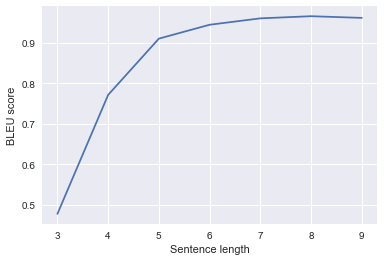

In [439]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
plt.plot([3,4,5,6,7,8,9], [bleu_len3, bleu_len4, bleu_len5, bleu_len6, bleu_len7, bleu_len8, bleu_len9])
plt.xlabel('Sentence length')
plt.ylabel('BLEU score')
plt.show()

# about BLEU score
# Intelligibility or grammatical correctness are not taken into account

# BLEU is designed to approximate human judgement at a corpus level, 
# and performs badly if used to evaluate the quality of individual sentences.

# Another problem with BLEU scores is that they tend to favor short translations (but not in training data case?)

In [343]:
evaluateSentence(encoder1, attn_decoder1, "ik ben jong .")

['i', 'am', 'young', '.', '<EOS>']

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




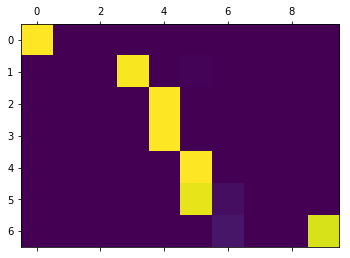

In [25]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = ik ben .
output = i am at home . <EOS>


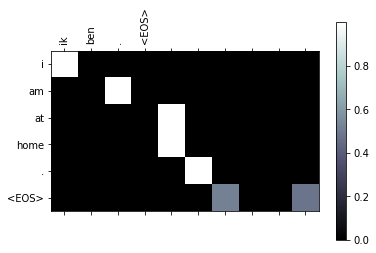

In [26]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("ik ben .")



Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


